In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import torch

In [4]:
def images(archivo_csv, carpeta):
    df = pd.read_csv(archivo_csv)

    bandgap = df['band_gap_mean']
    diccionario = {}

    for i, row in df.iterrows():
        lista_str_x = row['x1'][1:-1].split(", ")
        lista_str_y = row['x2'][1:-1].split(", ")
    
        x = [float(numero) for numero in lista_str_x]
        y = [float(numero) for numero in lista_str_y]
        Bandgap = float(bandgap[i])
    
        clave = f'dato_{i}'  
        diccionario[clave] = {'X': x, 'Y': y, 'Bandgap': Bandgap}
        
    if not os.path.exists(carpeta):
        os.makedirs(carpeta)

    for clave, valores in diccionario.items():
        ruta_imagen = os.path.join(carpeta, f"{clave}.png")  
        
        plt.figure(figsize= (3, 3))
        plt.plot(valores['X'], valores['Y'], '-', color='k', linewidth=1.5)
        
        #plt.xlim(min(valores['X']), max(valores['X']))
        #plt.ylim(min(valores['Y'])-2, max(valores['Y'])+2)
        
        plt.xticks([])
        plt.yticks([])
        plt.tight_layout()
        plt.savefig(ruta_imagen, bbox_inches='tight', pad_inches=0)  
        plt.close() 
        
    return diccionario

archivo_csv = "Dataset/Bandgap/dataset_Paper1_Fluorite.csv"
archivo_csv1 = "Dataset/Bandgap/dataset_Paper2_Mukesh.csv"
carpeta = "Dataset/img/Flourite"
carpeta1 = "Dataset/img/Muskesh"


fluorite = images(archivo_csv, carpeta)
muskesh = images(archivo_csv1, carpeta1)

In [5]:
df_fluorite = pd.DataFrame.from_dict(fluorite, orient='index')

df_muskesh = pd.DataFrame.from_dict(muskesh, orient='index')

dato_0_row = df_fluorite.loc["dato_0"]
print(dato_0_row)



X          [1.12726309532197, 1.1282891794029504, 1.12931...
Y          [0.0060821480926347695, 0.0037368379172620283,...
Bandgap                                                5.718
Name: dato_0, dtype: object


In [7]:
def derivada_discreta(y):
    dy = np.gradient(y)
    
    return dy

carpeta_prueba = 'Dataset/img/Derivada_Flourite'

if not os.path.exists(carpeta_prueba):
    os.makedirs(carpeta_prueba)

for index, row in df_fluorite.iterrows():
    y_0 = row['Y']
    x_0 = row['X']
    
    derivete_y = derivada_discreta(y_0)
    
    ruta_imagen_prueba = os.path.join(carpeta_prueba, f"prueba_{index}.png") 

    plt.figure(figsize=(3, 3))
    plt.plot(x_0, derivete_y, '-', color='k', linewidth=1.5)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

    plt.savefig(ruta_imagen_prueba, bbox_inches='tight', pad_inches=0)  

    plt.close()

print("Imágenes guardadas exitosamente en la carpeta 'prueba'.")


Imágenes guardadas exitosamente en la carpeta 'prueba'.


In [10]:

carpeta_prueba = 'Dataset/img/Derivada_Muskesh'
if not os.path.exists(carpeta_prueba):
    os.makedirs(carpeta_prueba)

for index, row in df_muskesh.iterrows():
    y_0 = row['Y']
    x_0 = row['X']
    derivete_y = derivada_discreta(y_0)
    ruta_imagen_prueba = os.path.join(carpeta_prueba, f"prueba_{index}.png") 
    plt.figure(figsize=(3, 3))
    plt.plot(x_0, derivete_y, '-', color='k', linewidth=1.5)
    
    plt.xticks([])
    plt.yticks([])
    
    plt.tight_layout()
    plt.savefig(ruta_imagen_prueba, bbox_inches='tight', pad_inches=0)  
    plt.close()

print("Imágenes guardadas exitosamente en la carpeta 'pruebaMuskesh'.")

Imágenes guardadas exitosamente en la carpeta 'pruebaMuskesh'.


In [11]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from torch.utils.data import DataLoader, random_split

class CustomImageDataset(Dataset):
    def __init__(self, root_dir, root_dir_derivative, dataframe, transform=None):
        self.root_dir = root_dir
        self.root_dir_derivative = root_dir_derivative
        self.dataframe = dataframe
        self.transform = transform
        self.images = os.listdir(root_dir)
        self.images_derivative = os.listdir(root_dir_derivative)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.images[idx])
        img_name_derivative = os.path.join(self.root_dir_derivative, self.images_derivative[idx])

        image = Image.open(img_name).convert("L")
        image_derivative = Image.open(img_name_derivative).convert("L")

        if self.transform:
            image = self.transform(image)
            image_derivative = self.transform(image_derivative)

        image = torch.cat((image, image_derivative), dim=0)

        img_filename = self.images[idx].split('.')[0]

        label = self.dataframe.loc[self.dataframe.index == img_filename, 'Bandgap'].values[0]

        label = torch.tensor(label, dtype=torch.float)  

        return image, label

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  
])

dataset_fluorite = CustomImageDataset(
    root_dir=r'C:\Users\rueda\U\RedesNeuronales\proyecto final\imagenesFlourite2',
    root_dir_derivative=r'C:\Users\rueda\U\RedesNeuronales\proyecto final\pruebaFlourite',
    dataframe=df_fluorite,
    transform=transform
)

train_size_fluorite = int(0.8 * len(dataset_fluorite))
test_size_fluorite = len(dataset_fluorite) - train_size_fluorite

train_dataset_fluorite, test_dataset_fluorite = random_split(dataset_fluorite, [train_size_fluorite, test_size_fluorite])

train_loader_fluorite = DataLoader(train_dataset_fluorite, batch_size=4, shuffle=True)
test_loader_fluorite = DataLoader(test_dataset_fluorite, batch_size=4, shuffle=False)


In [12]:
test_dataset_fluorite.dataset.__dict__

{'root_dir': 'C:\\Users\\rueda\\U\\RedesNeuronales\\proyecto final\\imagenesFlourite2',
 'root_dir_derivative': 'C:\\Users\\rueda\\U\\RedesNeuronales\\proyecto final\\pruebaFlourite',
 'dataframe':                                                           X  \
 dato_0    [1.12726309532197, 1.1282891794029504, 1.12931...   
 dato_1    [1.12726309532197, 1.1282891794029504, 1.12931...   
 dato_2    [1.12726309532197, 1.1282891794029504, 1.12931...   
 dato_3    [1.12726309532197, 1.1282891794029504, 1.12931...   
 dato_4    [1.12726309532197, 1.1282891794029504, 1.12931...   
 ...                                                     ...   
 dato_525  [1.1272693495638397, 1.1282958218178423, 1.129...   
 dato_526  [1.1272693495638397, 1.1282958218178423, 1.129...   
 dato_527  [1.1272693495638397, 1.1282958218178423, 1.129...   
 dato_528  [1.1272693495638397, 1.1282958218178423, 1.129...   
 dato_529  [1.1272693495638397, 1.1282958218178423, 1.129...   
 
                                 

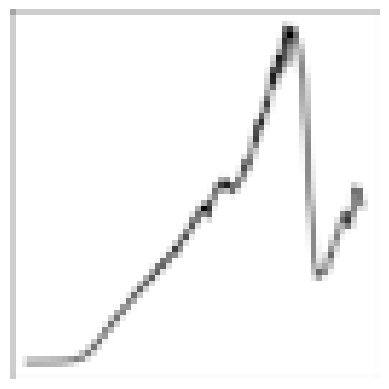

In [13]:
index = 0
image, label = test_dataset_fluorite[index]

image = image[0].numpy()  

mean = 0.5
std = 0.5
image = (image * std) + mean
image = image.clip(0, 1)  

plt.imshow(image, cmap='gray')
plt.axis('off')
plt.show()


In [355]:
import torch.nn as nn
import torch.optim as optim

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(2, 32, kernel_size=3, stride=1, padding=1) 
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 16 * 16, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 1)  

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = x.view(-1, 64 * 16 * 16)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        return x

# Instanciar el modelo para fluorite
model_fluorite = CNN()

# Definir la función de pérdida y los optimizadores para el modelo de fluorite
criterion = nn.MSELoss()  # Mean Squared Error Loss for regression
optimizer_fluorite = optim.Adam(model_fluorite.parameters(), lr=0.001)

# Entrenamiento del modelo para fluorite
num_epochs = 35
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader_fluorite, 0):
        optimizer_fluorite.zero_grad()
        outputs = model_fluorite(inputs)
        loss = criterion(outputs, labels.view(-1, 1).float())
        loss.backward()
        optimizer_fluorite.step()

        running_loss += loss.item()
        if i % 100 == 99: 
            print(f'Fluorite - Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader_fluorite)}], Loss: {running_loss / 100}')
            running_loss = 0.0

print('Finished Training for Fluorite')


Fluorite - Epoch [1/35], Step [100/424], Loss: 1.0249666109291138
Fluorite - Epoch [2/35], Step [100/424], Loss: 0.2919020929769613
Fluorite - Epoch [3/35], Step [100/424], Loss: 0.08506361341103912
Fluorite - Epoch [4/35], Step [100/424], Loss: 0.03508959876955487
Fluorite - Epoch [5/35], Step [100/424], Loss: 0.03883338475367054
Fluorite - Epoch [6/35], Step [100/424], Loss: 0.03459688914823346
Fluorite - Epoch [7/35], Step [100/424], Loss: 0.02126176402787678
Fluorite - Epoch [8/35], Step [100/424], Loss: 0.01844557619537227
Fluorite - Epoch [9/35], Step [100/424], Loss: 0.011632217992446386
Fluorite - Epoch [10/35], Step [100/424], Loss: 0.022752267093164847
Fluorite - Epoch [11/35], Step [100/424], Loss: 0.01174305046966765
Fluorite - Epoch [12/35], Step [100/424], Loss: 0.010157739206333645
Fluorite - Epoch [13/35], Step [100/424], Loss: 0.005851717351761181
Fluorite - Epoch [14/35], Step [100/424], Loss: 0.006758842392882798
Fluorite - Epoch [15/35], Step [100/424], Loss: 0.0069

In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


def compute_errors(model, input, target, batch_size):
    test_data = torch.utils.data.TensorDataset(input, target)
    test_loader = DataLoader(test_data, batch_size=batch_size)

    model.eval() 

    y_true = []
    y_pred = []
    total_errors = 0 

    for inputs, targets in test_loader:
        with torch.no_grad():
        
            inputs = inputs.permute(0, 3, 1, 2)  
            outputs = model(inputs)

        _, predicted = torch.max(outputs, 1)

        predicted = torch.argmax(outputs, dim=1)

        total_errors += torch.sum(predicted != targets.argmax(1)).item()

       
        y_true.extend(targets.argmax(1).tolist())
        y_pred.extend(predicted.tolist())

  
    y_true_multiclass = np.array(y_true)
    y_pred_multiclass = np.array(y_pred)

  
    accuracy = accuracy_score(y_true_multiclass, y_pred_multiclass)
    precision = precision_score(y_true_multiclass, y_pred_multiclass, average='macro')
    recall = recall_score(y_true_multiclass, y_pred_multiclass, average='macro')
    f1 = f1_score(y_true_multiclass, y_pred_multiclass, average='macro')

    return accuracy, precision, recall, f1, total_errors


In [ ]:
batch_size = 500 
accuracy, precision, recall, f1, total_errors  = compute_errors(model_fluorite, test_input, test_target_onehot, batch_size)

print(f"Numero total de errores: {total_errors:.4f}")
print(f"Exactitud (Accuracy): {accuracy:.4f}")
print(f"Precisión (Precision): {precision:.4f}")
print(f"(Recall): {recall:.4f}")
print(f"Puntuación F1 (F1 Score): {f1:.4f}")

In [366]:
import torch
import torchvision.transforms as transforms
from PIL import Image

# Cargar la imagen
image_path_fluorite = "imagenesFlourite2/dato_9.png"

data = image_path_fluorite.split("/")[-1].split(".")[0]

image_path_derivative = "pruebaFlourite/prueba_dato_9.png"  
image_fluorite = Image.open(image_path_fluorite).convert("L") 
image_derivative = Image.open(image_path_derivative).convert("L")  

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

image_fluorite = transform(image_fluorite) 
image_derivative = transform(image_derivative) 

image = torch.cat((image_fluorite, image_derivative), dim=0)

#image, label = test_dataset_fluorite.__getitem__(105)

image = image.unsqueeze(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image = image.to(device)

model_fluorite = model_fluorite.to(device)

model_fluorite.eval()  
with torch.no_grad():
    outputs = model_fluorite(image)

predicted_bandgap = outputs.mean().item()

print(f"Predicción de Bandgap para el {data}:", predicted_bandgap)


Predicción de Bandgap para el dato_9: 4.745386123657227


In [368]:
fluorite['dato_9']['Bandgap']

4.828

In [241]:
import torch
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

# Crear un DataLoader para el conjunto de datos de prueba
test_loader = DataLoader(test_dataset_fluorite, batch_size=1, shuffle=False)

# Mover el modelo al dispositivo (GPU si está disponible, de lo contrario, CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_fluorite.to(device)


all_predictions = []

model_fluorite.eval()  
with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)  
        outputs = model_fluorite(images)
        
        predicted_bandgap = outputs.mean().item()
        
        all_predictions.append(predicted_bandgap)

for i, prediction in enumerate(all_predictions, 1):
    print(f"Predicción {i}: {prediction}")


Predicción 1: 1.9955698251724243
Predicción 2: 1.950727105140686
Predicción 3: 1.9624487161636353
Predicción 4: 1.9784446954727173
Predicción 5: 1.8182519674301147
Predicción 6: 1.9422053098678589
Predicción 7: 1.876940131187439
Predicción 8: 1.9363433122634888
Predicción 9: 2.0570759773254395
Predicción 10: 1.9719270467758179
Predicción 11: 1.950160264968872
Predicción 12: 1.910474181175232
Predicción 13: 1.946887493133545
Predicción 14: 1.8775862455368042
Predicción 15: 3.174870491027832
Predicción 16: 4.925447463989258
Predicción 17: 2.141430377960205
Predicción 18: 1.9044753313064575
Predicción 19: 4.7806806564331055
Predicción 20: 2.0915703773498535
Predicción 21: 1.8984391689300537
Predicción 22: 5.582221508026123
Predicción 23: 2.082486867904663
Predicción 24: 1.8995717763900757
Predicción 25: 1.9867185354232788
Predicción 26: 1.9601229429244995
Predicción 27: 1.9618557691574097
Predicción 28: 5.0683441162109375
Predicción 29: 1.9064160585403442
Predicción 30: 2.063443183898926


In [193]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_fluorite = CNN()

model_fluorite.to(device)

criterion = nn.MSELoss()

total_loss = 0.0
num_samples = 0
model_fluorite.eval()  
with torch.no_grad():
    for images, labels in test_loader_fluorite:  
        images = images.to(device)  
        labels = labels.to(device)  

        outputs = model_fluorite(images)
        loss = criterion(outputs, labels)
        total_loss += loss.item() * images.size(0)
        num_samples += images.size(0)

mse = total_loss / num_samples
print('Mean Squared Error (MSE) of the model on the test images:', mse)

Mean Squared Error (MSE) of the model on the test images: 5.752558429286165


In [188]:
import torch
import torch.nn as nn
import numpy as np

# Función para calcular el Coeficiente de Determinación (R²)
def r_squared(outputs, labels):
    mean_labels = torch.mean(labels, dim=0)
    total_sum_of_squares = torch.sum((labels - mean_labels)**2, dim=0)
    residual_sum_of_squares = torch.sum((labels - outputs)**2, dim=0)
    r2 = 1 - (residual_sum_of_squares / total_sum_of_squares)
    return r2

# Definir el dispositivo: GPU si está disponible, de lo contrario, usar CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_fluorite = CNN()

model_fluorite.to(device)

criterion = nn.MSELoss()

total_r2 = 0.0
num_samples = 0
model_fluorite.eval() 
with torch.no_grad():
    for images, labels in test_loader_fluorite: 
        images = images.to(device)
        labels = labels.to(device) 

        outputs = model_fluorite(images)
        
        r2 = r_squared(outputs, labels)
        
        total_r2 += torch.sum(r2).item()
        num_samples += images.size(0)

mean_r2 = total_r2 / num_samples
print('R² of the model on the test images:', mean_r2)


R² of the model on the test images: -1871.4806416979377


In [370]:
import torch.nn as nn
import torch.optim as optim

class ShallowCNN(nn.Module):
    def __init__(self):
        super(ShallowCNN, self).__init__()
        self.conv1 = nn.Conv2d(2, 16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(16 * 32 * 32, 128)
        self.relu2 = nn.ReLU()
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = x.view(-1, 16 * 32 * 32)
        x = self.fc1(x)
        x = self.relu2(x)
        x = self.fc2(x)
        return x
